<a href="https://colab.research.google.com/github/0xQuirKai/0xQuirkai/blob/main/aRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://www.uber.com/en-IN/blog/from-monitoring-to-observability-cloud-native/",
    "https://www.uber.com/en-IN/blog/from-static-rate-limiting-to-intelligent-load-management",
    "https://www.uber.com/en-IN/blog/apache-hudi-at-uber",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [147]:
docs[0][0].page_content.strip()[:1000]

'From Monitoring to Observability: Our Ultra-Marathon to a Cloud-Native Platform | Uber Blog \n\n\n       \n\n  Skip to main content\n\nUber BlogExploreProductsEarnResources for driving and delivering with UberRideExperiences and information for people on the moveBusinessTransforming the way companies move and feed their peopleHigher EducationEnhancing campus transportationTransitExpanding the reach of public transportationCompanyCareersExplore how Uber employees from around the globe are helping us drive the world forward at work and beyondEngineeringThe technology behind Uber EngineeringNewsroomUber news and updates in your countryUber.comProduct, how-to, and policy content—and moreMoreNo resultsENSearchSign upUber BlogSign up,EngineeringEngineeringChevron downOverviewBackendCultureData / MLMobileSecurityUber AIWebResearchMoreChevron down smallNo resultsStay up to date with the latest from Uber EngineeringFollow us on LinkedInFollow us on LinkedInStay up to date with the latest from 

In [148]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [149]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.tools import tool

# 1. Use free local embeddings instead of OpenAI
# This will download the model to your Colab session automatically
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# 2. Setup the same In-Memory store
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=embeddings
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 6})

# 3. Define your tool
@tool
def retrieve_blog_posts(query: str) -> str:
    """Search and return information about Lilian Weng blog posts."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])
tools = [retrieve_blog_posts,web_search_tool]
# 4. Invoke the tool
retriever_tool = retrieve_blog_posts
response = retriever_tool.invoke({"query": "types of reward hacking"})
print(response)

This architecture also supports interactive AI agents, like a Slack bot, that act as a pacer during an incident. Engineers can ask questions in natural language (“How have alerts for this site code trended over the last 24 hours?“) and get immediate, context-rich answers, helping them push through the toughest parts of an incident.

Areas for Improvement
Despite the gains from Cinnamon, some key challenges remained, highlighting the need for a unified platform.

It ingests alerts asynchronously, processes them in parallel, and ensures that critical events reach the right teams without flooding Slack® or PagerDuty® with noise.
Think of it as an intelligent checkpoint system:

An AI engine processes all alert sources to provide advanced insights into network behavior patterns. By analyzing past performance, it helps engineers pinpoint root causes faster, significantly lowering our MTTR (Mean Time To Repair) and helping us set a new personal best for incident resolution.

The Apache Hudi 

In [150]:
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState
from google.colab import userdata

# 1. Initialize Groq (Get a free key at console.groq.com)
# Using 'llama-3.3-70b-versatile' which is free and very smart
response_model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    api_key=userdata.get('groq')
)

def generate_query_or_respond(state: MessagesState):
    """
    Decision Node: The model reads the chat history and decides:
    1. Do I have the answer? -> Respond to user.
    2. Do I need the blog? -> Call retriever_tool.
    """
    # Bind the free tool we created earlier to the Groq model
    llm_with_tools = response_model.bind_tools([retriever_tool])

    # Process the messages
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (2afmhnz6d)
 Call ID: 2afmhnz6d
  Args:
    query: types of reward hacking


In [151]:
from pydantic import BaseModel, Field
from typing import Literal

# 1. Initialize Groq as your grader (Free Tier)
# Llama-3.3-70b is excellent for complex reasoning like relevance grading
grader_model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    api_key=userdata.get('groq')
)

# 2. Define the Pydantic schema (remains the same)
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""
    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n"
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)
def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""

    # Extract the original user question and the last retrieved document
    question = state["messages"][0].content
    context = state["messages"][-1].content

    # 3. Use the free Groq model with structured output
    # This forces the LLM to return exactly our GradeDocuments object
    structured_grader = grader_model.with_structured_output(GradeDocuments)

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = structured_grader.invoke([{"role": "user", "content": prompt}])

    score = response.binary_score.lower().strip()

    # 4. Routing Logic
    if score == "yes":
        print("---GRADE: DOCUMENT RELEVANT---")
        return "generate_answer"
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        return "rewrite_question"

In [152]:
from langchain.messages import HumanMessage

REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [HumanMessage(content=response.content)]}

In [153]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [154]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

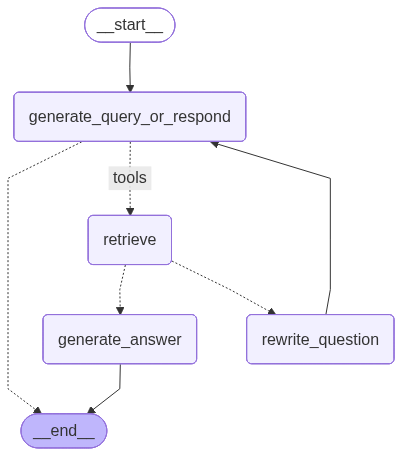

In [155]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [156]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How does Uber distinguish between 'Monitoring' and 'Observability' in the context of their ultra-marathon analogy?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

<brave_search> How does Uber distinguish between 'Monitoring' and 'Observability' in the context of their ultra-marathon analogy.





In [157]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize the search tool
web_search_tool = TavilySearchResults(k=3)

def web_search(state: MessagesState):
    """
    Fallback Node: If articles are irrelevant, search the web.
    """
    print("---FALLBACK TO WEB SEARCH---")

    # Get the original question
    question = state["messages"][0].content

    # Run the search
    search_results = web_search_tool.invoke({"query": question})

    # Format the results into a single string
    docs_content = "\n\n".join([res["content"] for res in search_results])

    # Wrap in a message so the LLM can read it in the next node
    search_message = f"Web Search Results for '{question}':\n\n{docs_content}"

    return {"messages": [{"role": "system", "content": search_message}]}

In [158]:
from langgraph.prebuilt import ToolNode, tools_condition

# 1. Create a ToolNode - it handles the Pydantic validation for you!
retrieve_node = ToolNode(tools)

workflow = StateGraph(MessagesState)

# 2. Add your nodes
workflow.add_node("agent", generate_query_or_respond)
workflow.add_node("retrieve", retrieve_node) # <-- Use the ToolNode here
workflow.add_node("grade", grade_documents)
workflow.add_node("web_search", web_search)

# 3. Connect them correctly
workflow.add_edge(START, "agent")

# Use 'tools_condition' to decide if we go to the retriever
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve", # If LLM wants a tool, go to ToolNode
        END: END             # If LLM just answers, stop
    }
)

# After the ToolNode finishes, it returns a ToolMessage.
# NOW you go to your grader to check those results.
workflow.add_edge("retrieve", "grade")

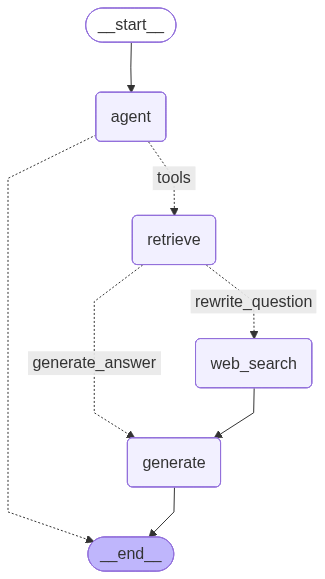

In [159]:
from IPython.display import Image, display

# This generates a PNG of your specific graph structure
display(Image(app.get_graph().draw_mermaid_png()))

In [169]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Recommended: 3–6 results is usually plenty
tavily_tool = TavilySearchResults(max_results=5)

# Give it a clear, neutral name the model will actually use
# (you can leave it as default "tavily_search_results_json" or rename)
tools = [tavily_tool]  # + your other tools

# Bind them properly
llm_with_tools = llm.bind_tools(tools)

NameError: name 'llm' is not defined

In [168]:
# 1. Define your test cases
test_questions = [
    "hi.", # Path A: Local Retrieval should work
    "Who won the last Super Bowl?"           # Path B: Local should fail, Web Search should trigger
]

# 2. Run the loop
for question in test_questions:
    print(f"\n{'='*20}\nTESTING: {question}\n{'='*20}")
    inputs = {"messages": [("user", question)]}

    for chunk in app.stream(inputs, stream_mode="values"):
        # The 'values' mode shows the full state at each step
        last_msg = chunk["messages"][-1]

        # Pretty print the logic
        if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
            print(f"Decision: Agent is calling tool '{last_msg.tool_calls[0]['name']}'")
        elif last_msg.type == "tool":
            print(f"Update: Tool returned {len(last_msg.content)} characters of data.")
        else:
            print(f"Final Answer: {last_msg.content[:100]}...")


TESTING: hi.
Final Answer: hi....
Final Answer: I'm here to help. What would you like to do?...

TESTING: Who won the last Super Bowl?
Final Answer: Who won the last Super Bowl?...
Final Answer: <brave_search>Search for the last Super Bowl winner</brave_search>...
